# Simulate Chromatin Bound by HP1 and PRC1

Here, we prepare and run a Monte Carlo simulation of a wormlike chain modeled after chromatin. The polymer includes 100 monomeric units, each spaced by 16.5 nm, representing a DNA linker of approximately 50 base pairs. Twist is not considered in this simulation. The polymer is confined to a 900 nm radius spherical confinement, representing a single chromosome territory. The simulation is run for 100 snapshots, each with 100,000 MC iterations.

Each monomeric unit of the simulation represents a nucleosome with two tails. Each tail can be bound at separate sites by Heterchromatin Protein 1 (HP1) and Polycomb Repressive Complex 1 (PRC1). The proteins preferentially bind tails of the nucleosome modified with histone H3 lysine 9 trimethylation (H3K9me3) and histone H3 lysine 27 trimethylation (H3K27me3), respectively. By default (and in this example), we model HP1 and PRC1 as behaving identically and interacting only  with proteins of the same kind. We do not track explicit interactions between proteins and nucleosomes. Instead, we use an efficient field theoretic approach, abstracting components into a density field which dictates the magnitude of their interactions.
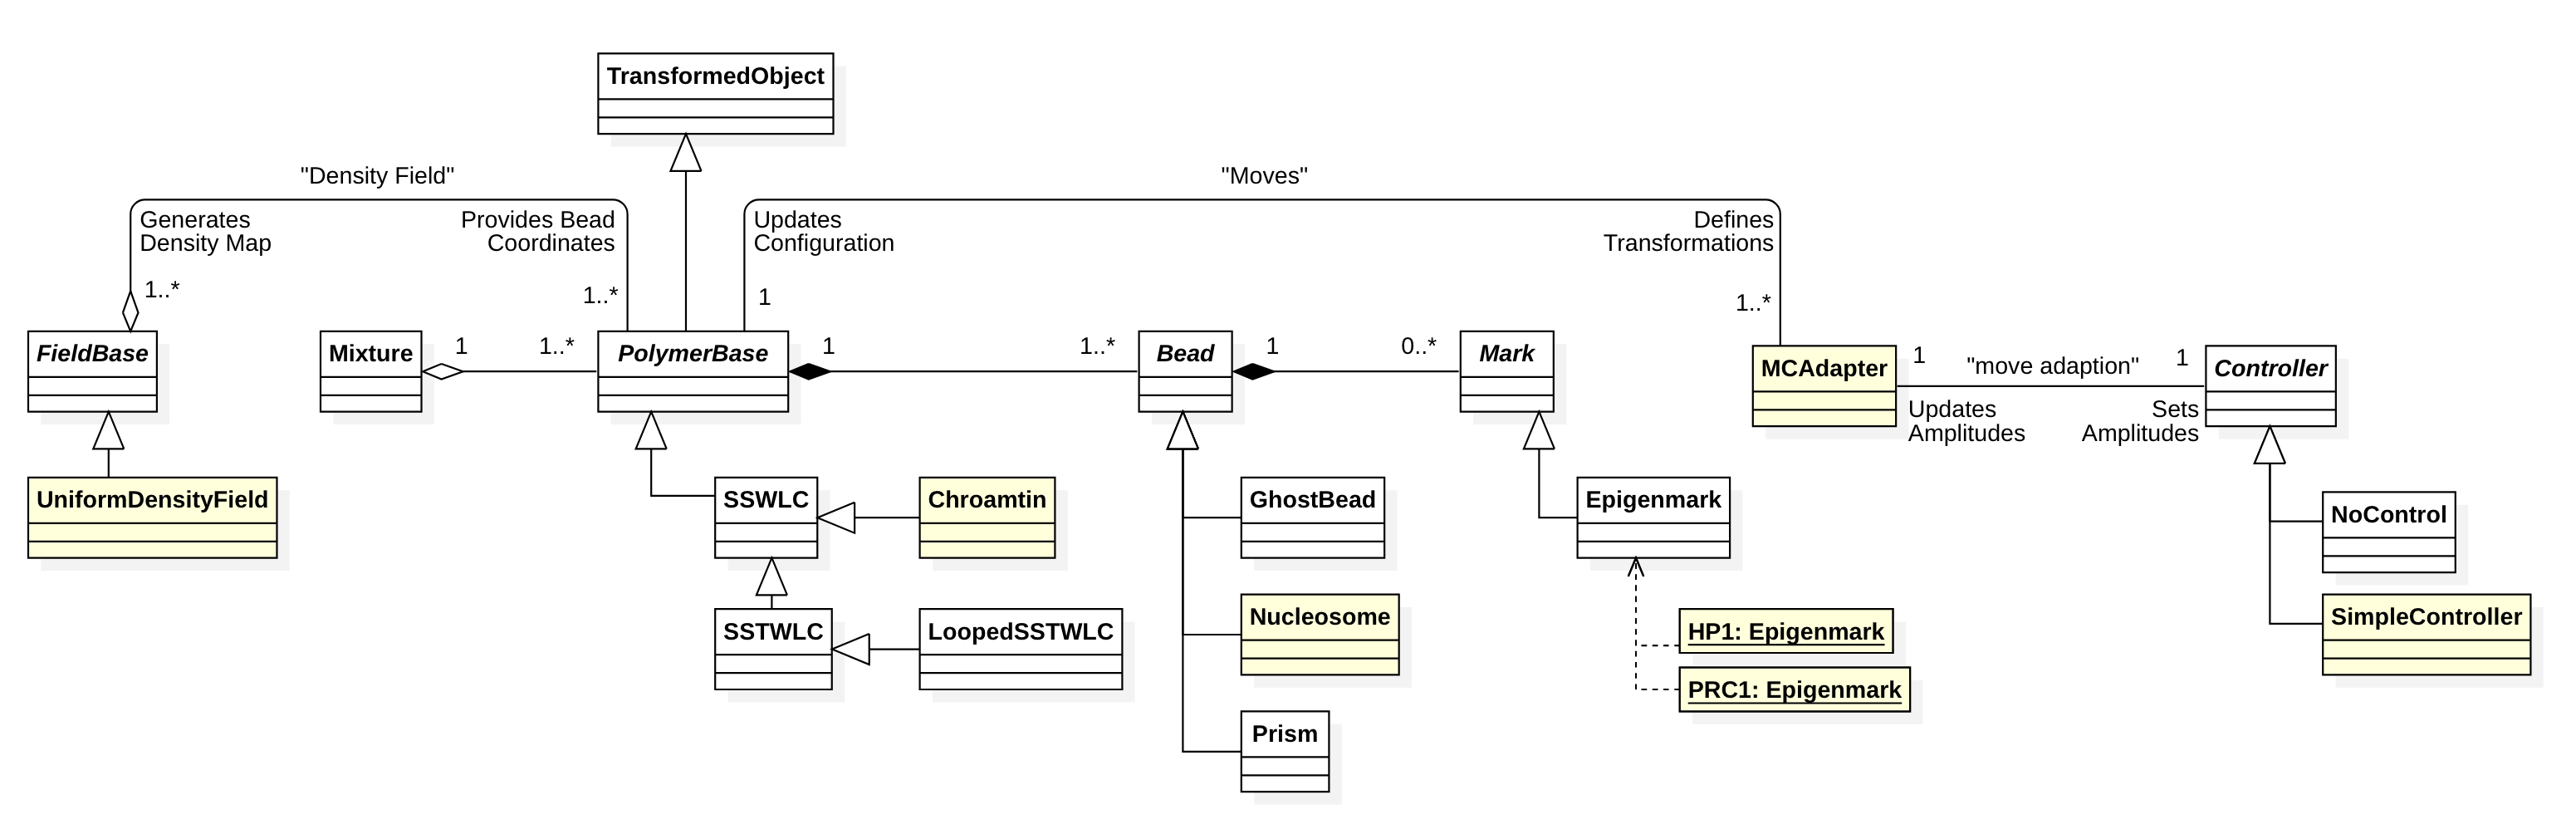

### Setup

Install necessary modules, add the package root directory to the system path, and change working directory to root. Every simulation will involve similar setup steps.

**Do not run the setup cell more than once, except after restarting the kernel.** There is no way to consistently track the directory containing the notebook.

In [1]:
# Built-in modules
import os
import sys

# Insert package root to system path
cwd = os.getcwd()
parent_dir = cwd + "/../.."
sys.path.insert(1, parent_dir)

print("Directory containing the notebook:")
print(cwd)

Directory containing the notebook:
/home/users/jwakim/CodeDev/chromo_20Jan2022/doc/examples


In [2]:
# External modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Package modules
import chromo.mc as mc
from chromo.polymers import Chromatin
import chromo.marks
from chromo.fields import (
    UniformDensityField, get_blocks, get_neighboring_bins, assign_beads_to_bins
)
import chromo.mc.mc_controller as ctrl
from chromo.util.reproducibility import get_unique_subfolder_name
import chromo.util.poly_stat as ps

In [3]:
# Change working directory to package root
os.chdir(parent_dir)
print("Root Directory of Package: ")
print(os.getcwd())

Root Directory of Package: 
/home/users/jwakim/CodeDev/chromo_20Jan2022


### Specify Epigenetic Marks

Epigenetic marks are collectively stored in a data frame that we call the "mark collection." We can generate the mark collection using the `make_mark_collection` function in the `chromo.marks` module. The mark collection accepts as an input a list of epigenetic mark objects. Certain epigenetic mark objects are pre-implemented in the `chromo.marks` module and can be instantiated by name using the `get_by_name` method in the `chromo.marks` module. Below, we instantiate two epigenetic mark objects (for HP1 and PRC1) and we create a mark collection containing them.

In [4]:
# Instantiate the HP1 mark, which is pre-defined in the `chromo.marks` module
hp1 = chromo.marks.get_by_name('HP1')

# Instantiate the PRC1 mark ,which is pre-defined in the `chromo.marks` module
prc1 = chromo.marks.get_by_name('PRC1')

# Create the mark collection
marks = chromo.marks.make_mark_collection([hp1, prc1])

### Specify Confinement

The behavior of confining boundaries are defined in the `chromo.field` module. The confinement type is specified as a string name. The confinement length depends on the confinement type (as should be documented in the `chromo.field` module) and is specified as a float.

Here we define a spherical confinement with a 900 nm radius, representing a single chromosome territory (Cremer & Cremer 2001).

In [5]:
confine_type = "Spherical"
confine_length = 900

### Instantiate Polymer

Various polymer models are defined in the `chromo.polymers` model. All polymer classes share the attributes and methods in the `PolymerBase` class. We have defined a `Chromatin` polymer as a subclass of `SSWLC`, which is based on the stretchable, shearable wormlike chain model.

We instantiate a chromatin polymer with 100 beads, each separated by 16.5 nm (corresponding to a linker length of approximately 50 base pairs). The chromatin chain is initialized as a Gaussian random walk inside the spherical confinement.

Each bead of the polymer can be defined with chemical modification states. Chemical modification states are required for each bound mark. Since each bead represents a nucleosome which can be bound by HP1 and PRC1, the chemical modifications we are interested in are H3K9me3 and H3K27me3. For each chemical modification, the chemical modification state is `0` if the bead does not have the chemical modification, `1` if the bead has the chemical modification on a single tail, and `2` if the bead has the chemical modification on both tails. Each chemical modification state is read from a file, and the `load_seqs` method of the `PolymerBase` class facilitates this. We initialize HP1 binding states to match the H3K9me3 modification pattern and the PRC1 binding states to match the H3K27me3 modification pattern. This means that each modified tail is initially bound by a mark.

In [6]:
num_beads = 100
bead_spacing = 16.5

chem_mods_paths = np.array([
    "chromo/chemical_mods/H3K9me3_100.txt",
    "chromo/chemical_mods/H3K27me3_100.txt"
])
chemical_mods = Chromatin.load_seqs(chem_mods_paths)
states = chemical_mods.copy()

chromatin = Chromatin.confined_gaussian_walk(
    'Chr-1',
    num_beads,
    bead_spacing,
    states=states,
    confine_type=confine_type,
    confine_length=confine_length,
    mark_names=np.array(['HP1', 'PRC1']),
    chemical_mods=chemical_mods,
    chemical_mod_names=np.array(['H3K9me3', 'H3K27me3'])
)

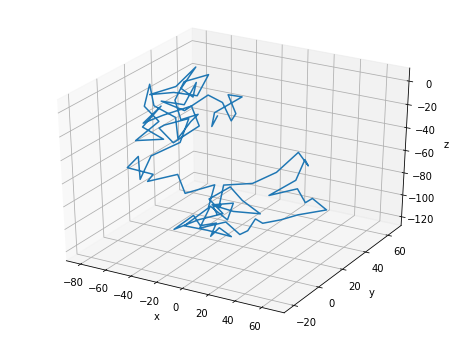

In [7]:
x = chromatin.r[:, 0]
y = chromatin.r[:, 1]
z = chromatin.r[:, 2]

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')
ax.plot3D(x, y, z)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

### Define Uniform Density Field

We leverage a field theoretic approach to model interactions between nucleosomes and bound marks. The approach enables us to model full human chromosomes at nucleosome scale resolution. The field tracks the density of the polymer and all marks in cubical voxels of space. To instantiate the field, we need to specify the dimensions of the voxel grid, the confinement, and all polymers and marks contained.

Here we instantiate a field that contains the spherical confinement with voxels of ~28.6 nm width in the x, y, and z directions.

In [8]:
n_bins_x = 63
n_bins_y = n_bins_x
n_bins_z = n_bins_x

x_width = 2 * confine_length
y_width = x_width
z_width = x_width

udf = UniformDensityField(
    polymers = [chromatin],
    marks = marks,
    x_width = x_width,
    nx = n_bins_x,
    y_width = y_width,
    ny = n_bins_y,
    z_width = z_width,
    nz = n_bins_z,
    confine_type = confine_type,
    confine_length = confine_length,
    chi = 1
)

### Specify Simulation

The simulator proposes and evaluates random configurational changes to chromatin, which include geometric transformations and effector protein binding/unbinding to the biopolymer.

##### Move and Bead Amplitudes

There are two ways to tune these configurational changes over the course of the simulation; we can either adjust the magnitude of the selection window for affected beads, or we can adjust the magnitude of the transformation itself. We define a "bead amplitude" to represent the maximum magnitude of the selection window for a move and a "move amplitude" to represent the maximum magnitude of the move's transformation. Note, changes in binding state do not have move amplitudes, since they do not involve a physical transformation. We restrict the move and bead amplitudes between bounds to ensure that MC moves do not become too large or too small. The bounds of the move and bead amplitudes are dependent on the polymers' sizes and are determined by the `get_amplitude_bounds` method in the `__init__` module of the `mc` directory.

In [9]:
amp_bead_bounds, amp_move_bounds = mc.get_amplitude_bounds(
    polymers = [chromatin]
)

##### Define MC Moves

Here, we identify exactly which MC moves we wish to include in the simulation. In this example, we use the following moves:

- **Slide:** Translation of a continuous segment of beads in a random direction
- **Crank-Shaft:** Rotation of an internal segment of the polymer about the axis containing the segment
- **End-Pivot:** Rotation of a segment on one end of the polymer about an arbitrary axis
- **Tangent Rotation:** Rotation of the tangent vectors of random beads in the polymer
- **Binding State:** Random changes in HP1 or PRC1 binding state

Since we often use this combination of MC moves, comprising all the move types we've implemented so far, we have defined a helper function called `all_moves` in the `chromo.mc.mc_controller` module to initialize the moves. The adaptable moves themselves are attributes of controllers that dynamically adjusts the move and bead amplitudes over the course of the simulation. Since each move is associated with a log file that may be used to track its acceptance rate, we need to specify an output directory for the simulation. The `get_unique_subfolder_name` function in the `chromo.util.reproducibility` module identifies a unique output directory name for the simulation.

In [10]:
latest_sim = get_unique_subfolder_name("output/sim_")
moves_to_use = ctrl.all_moves(
    log_dir=latest_sim,
    polymers=[chromatin],
    bead_amp_bounds=amp_bead_bounds.bounds,
    move_amp_bounds=amp_move_bounds.bounds,
    controller=ctrl.SimpleControl
)

##### Adjust Move Ratios

Each move is attempted a specified number of times per MC iteration. These define the ratio at which each move type is applied. By default, the number of attempts for each move in an MC iteration are: 60 slide moves, 30 crank-shaft moves, 1 end-pivot move, 60 tangent rotation moves, and 10 changes in mark binding state. We adjust these values so that each move is attempted just one time per MC iteration.

In [11]:
for move_controller in moves_to_use:
    move_controller.move.num_per_cycle = 1

##### Simulation Length

We define the simulation by the number of snapshots we would like to generate and the number of iterations of each move between the snapshots. Here, we specify a simulation producing 100 snapshots, each with 100,000 iterations of each MC move.

In [12]:
num_snapshots = 100
mc_steps_per_snapshot = 100000

### Run the Simulation

The `polymer_in_field` method defined in the `__init__` file of the `mc` directory initiates the simulation. Running the code block below generates a unique output directory and run the simulation.

In [13]:
%%capture
mc.polymer_in_field(
    polymers = [chromatin],
    marks = marks,
    field = udf,
    num_save_mc = mc_steps_per_snapshot,
    num_saves = num_snapshots,
    bead_amp_bounds = amp_bead_bounds,
    move_amp_bounds = amp_move_bounds,
    output_dir = 'output',
    mc_move_controllers = moves_to_use
)

### Evaluate Convergence

With the simulation complete, we want to check for energy and configurational convergence in the Monte Carlo snapshots. First we recall the latest simulation output directory. From that directory, we load the polymer configuration in each snapshot. We then evaluate the elastic energy of each bond and field energy contribution of each bead, giving us the total energy at each snapshot. We then check that the mean squared separation distance between beads $n = 10$ monomers apart on the chain also converges.

##### List Polymer Output Files

Polymer configurations are saved at each snapshot of the simulation in the simulation's output directory. All polymer configurations are saved with `.csv` extension and are prepended with the label `Chr`. The snapshot number is indicated after a hyphen and before the file extension in the polymer output file name.

In [14]:
# Load names of polymer configuration output files
output_files = os.listdir(latest_sim)
output_files = [
    f for f in output_files if f.endswith(".csv") and f.startswith("Chr")
]
snapshot = [int(f.split("-")[-1].split(".")[0]) for f in output_files]
sorted_snap = np.sort(np.array(snapshot))
output_files = [f for _, f in sorted(zip(snapshot, output_files))]

##### Calcualate Energies

The field and polymer classes each have a `compute_E` method for calculating total energy.

In [15]:
all_energies = []
polymer_energies = []
field_energies = []

for i, f in enumerate(output_files):
    snap = sorted_snap[i]
    output_path = str(latest_sim) + '/' + f

    r = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[1, 2, 3],
        dtype=float
    ).to_numpy()

    t3 = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[4, 5, 6],
        dtype=float
    ).to_numpy()

    states = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[10, 11],
        dtype=int
    ).to_numpy()

    chromatin.r = r.copy()
    chromatin.t3 = t3.copy()
    chromatin.states = states.copy()

    field_energy = udf.compute_E(chromatin)
    polymer_energy = chromatin.compute_E()
    polymer_energies.append(polymer_energy)
    field_energies.append(field_energy)
    all_energies.append(polymer_energy + field_energy)

##### Plot Energy Convergence

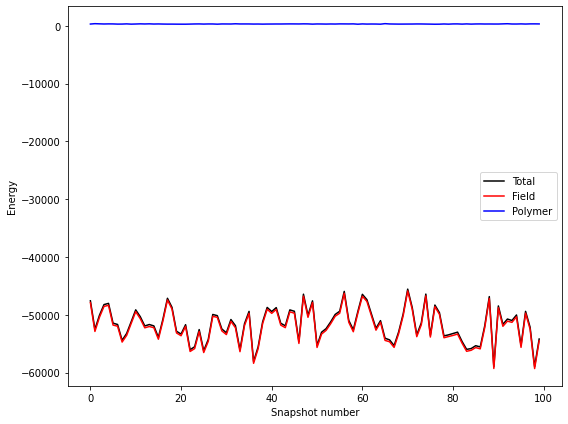

In [16]:
plt.figure(figsize=(8,6))
plt.plot(sorted_snap, all_energies, color='k', label='Total')
plt.plot(sorted_snap, field_energies, color='r', label='Field')
plt.plot(sorted_snap, polymer_energies, color='b', label='Polymer')
plt.xlabel("Snapshot number")
plt.ylabel("Energy")
plt.legend()
plt.tight_layout()
plt.show()

##### Calculate MSD

Check that the mean squared separation distance of beads $n = 10$ monomers apart on the chain converges during the simulation. In the `chromo.util.poly_stat` module, there is a method that does this calculation.

In [17]:
lp = 53     # Persistence length of DNA; in this example, `lp` has no effect
delta = 10  # Monomer monomer separation at which to calculate mean squared distance.

all_dists = []
for i, f in enumerate(output_files):
    snap = sorted_snap[i]
    output_path = str(latest_sim) + '/' + f
    r = pd.read_csv(
        output_path,
        header=0,
        skiprows=1,
        usecols=[1, 2, 3],
        dtype=float
    ).to_numpy()
    poly_stat = ps.PolyStats(r, lp, "overlap")
    windows = poly_stat.load_indices(delta)
    all_dists.append(poly_stat.calc_r2(windows))

##### Plot MSD Convergence

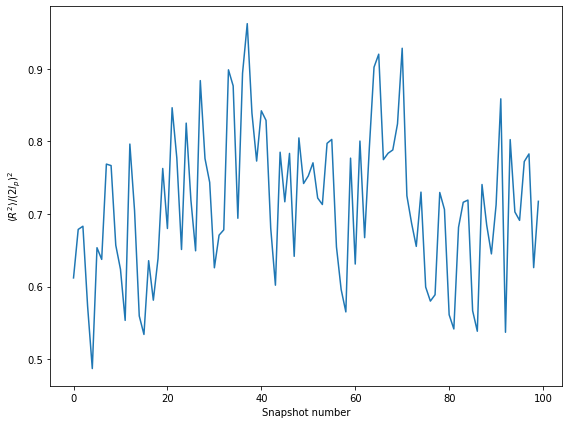

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(sorted_snap, all_dists)
plt.xlabel("Snapshot number")
plt.ylabel(r"$\langle R^2 \rangle /(2l_p)^2$")
plt.tight_layout()
plt.show()

### Generate Contact Map

We generate a heatmap of chromatin contacts between pairs of loci to emulate a Hi-C contact map that would be generated by experiments. Contacts frequencies are counted for discrete "blocks" of neighboring nucleosomes, each containing `block_size` beads; smaller block sizes indicate a higher-resolution contact map. Any pair of beads within `cutoff_dist` of one-another is counted as a contact. Contacts frequencies for each block are averaged between all snapshots following equilibration. We allow the polymer 70 snapshots to equilibrate.

In [19]:
block_size = 2
cutoff_dist = 100
num_equilibration = 70

for i, f in enumerate(output_files):

    if i < num_equilibration:
        continue

    output_path = str(latest_sim) + "/" + f

    r = np.ascontiguousarray(
        pd.read_csv(
            output_path,
            usecols=[1, 2, 3],
            header=0,
            skiprows=1
        ).to_numpy()
    )

    if i == num_equilibration:
        n_beads = len(r)
        blocks = get_blocks(n_beads, block_size)
        num_blocks = int(np.ceil(n_beads / block_size))
        contacts = np.zeros((num_blocks, num_blocks))
        contacts_at_sep = np.zeros(n_beads)

    bins = assign_beads_to_bins(
        r, num_beads, udf.nx, udf.ny, udf.nz, udf.x_width, udf.y_width,
        udf.z_width
    )
    n_bins = len(bins.keys())
    neighboring_bins = get_neighboring_bins(udf.nx, udf.ny, udf.nz)

    for j in bins.keys():
        for nbr_bin in neighboring_bins[j]:
            beads_in_bin = len(bins[nbr_bin])

            for k in range(beads_in_bin):
                for l in range(k, beads_in_bin):
                    ind_1 = bins[nbr_bin][k]
                    ind_2 = bins[nbr_bin][l]

                    block_1 = blocks[ind_1]
                    block_2 = blocks[ind_2]

                    diff = r[ind_1] - r[ind_2]
                    dist = np.linalg.norm(diff)

                    if dist <= cutoff_dist:
                        contacts[block_1, block_2] += 1
                        contacts[block_2, block_1] += 1
                        sep = np.abs(ind_2 - ind_1)
                        contacts_at_sep[sep] += 1

contacts /= len(output_files)
log_contacts = np.log10(contacts+1)
contacts_at_sep /= len(output_files)

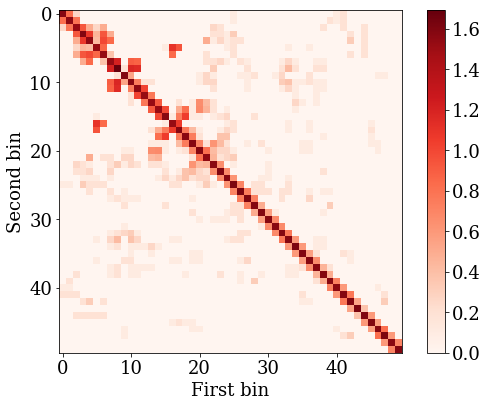

In [20]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 18}
plt.rc('font', **font)

plt.figure(figsize=(8, 6))
plt.imshow(log_contacts, cmap='Reds')
plt.colorbar()
plt.xlabel("First bin")
plt.ylabel("Second bin")
plt.tight_layout()
plt.show()

### Summary

We began by defining the components of our simulation, representing a single chromatin strand bound by two types of proteins, HP1 and PRC1. We then defined a Monte Carlo simulation, which includes multiple types of configurational changes applied and evaluated iteratively on the polymer. We finally assessed the predicted chromatin architectures at various snapshots, verifying convergence and generating a simulation-based contact map. This notebook predicts the structure of the chromatin strand from its patterns of H3K9me3 and H3K27me3 modification using a purely physics-based approach.